In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # will plot the confusion matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_columns', None)

In [4]:
# where the functions live!

# if we want a confusion matrix, we can run a model and call this function, passing in y_test and y_predictions
def confusion_matrix_plot(model, y_test, y_predictions):
    plt.rcParams['figure.figsize']=12,12
    sns.set_style("white")
    cm = confusion_matrix(y_test, y_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation = 270)
    plt.show()

# if we want a feature importance plot, we can run a model and call this function
def feature_importance_plot(x, model):
    feature_names = list(x.columns)
    plt.rcParams['figure.figsize']=7,7
    sns.set_style("white")
    feat_importances = pd.Series(model.feature_importances_, index=feature_names)
    feat_importances = feat_importances.groupby(level=0).mean()
    feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
    sns.despine()
    plt.show()


# if we want to visualized the results of a particular model, the scores can be passed in and printed
def print_results(accuracy, recall, precision, f1s):
    print("Accuracy: "+ "{:.2%}".format(accuracy))
    print("Recall: "+ "{:.2%}".format(recall))
    print("Precision: "+ "{:.2%}".format(precision))
    print("F1-Score: "+ "{:.2%}".format(f1s))


# this function 
def record_output(model_performance, y_test, y_predictions, algorithm_name, name):
    accuracy = accuracy_score(y_test, y_predictions)
    recall = recall_score(y_test, y_predictions, average='weighted')
    precision = precision_score(y_test, y_predictions, average='weighted')
    f1s = f1_score(y_test, y_predictions, average='weighted')

    row_index = len(model_performance)
    model_performance.loc[row_index] = [algorithm_name, accuracy, recall, precision, f1s, name]
    return model_performance


def logistical_classification(X_train, X_test, y_train):
        model = LogisticRegression(random_state=42, max_iter=3000).fit(X_train,y_train)
        y_predictions = model.predict(X_test) # These are the predictions from the test data
        return y_predictions


def K_neighbors(X_train, X_test, y_train):
        # does not take random_state arg
        model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
        y_predictions = model.predict(X_test) # These are the predictions from the test data.
        return y_predictions


def decision_tree(X_train, X_test, y_train):
        model = DecisionTreeClassifier(random_state=42).fit(X_train,y_train)
        y_predictions = model.predict(X_test) # These are the predictions from the test data
        return y_predictions


def extra_trees(X_train, X_test, y_train):
        model = ExtraTreesClassifier(random_state=42,n_jobs=-1).fit(X_train,y_train)
        y_predictions = model.predict(X_test) # These are the predictions from the test data
        return y_predictions


def random_forest(X_train, X_test, y_train):
    model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,bootstrap=True, random_state = 42).fit(X_train,y_train)
    y_predictions = model.predict(X_test) # These are the predictions from the test data.
    return model, y_predictions


def gradient_boost(X_train, X_test, y_train):
    model = GradientBoostingClassifier(random_state=42).fit(X_train,y_train)
    y_predictions = model.predict(X_test) # These are the predictions from the test data.
    return y_predictions


def neural_network(X_train, X_test, y_train):
    model = MLPClassifier(hidden_layer_sizes = (20,20,), 
                                  activation='relu', 
                                  solver='adam',
                                  batch_size=2000,
                                  verbose=0,
                                  random_state=42).fit(X_train,y_train)
    y_predictions = model.predict(X_test) # These are the predictions from the test data.
    return y_predictions


def recode_class(y_test, y_predicitions):
    # passes in y_test and y_predictions from the ML run
    y_test_recoded = pd.Series(y_test).where(lambda x: x.str.contains('Normal')==False, 'Normal')
    y_predictions_recoded = pd.Series(y_predicitions).where(lambda x: x.str.contains('Normal')==False, 'Normal')
    return y_test_recoded, y_predictions_recoded


def recode_label(y_test, y_predicitions):
    # passes in y_test and y_predictions from the ML run
    y_test_recoded = y_test.apply(lambda x: 0 if 'Normal' in x else 1)
    y_predictions_recoded = pd.Series(y_predicitions).apply(lambda x: 0 if 'Normal' in x else 1)
    return y_test_recoded, y_predictions_recoded

In [3]:
# # import the csvs!
# # 82k normalized 100/175:
# df_82k = pd.read_csv('csv files/82k_normalized_cats_train_test_split.csv', index_col = 0)

# # 82k not normalized 100/175:
# df_82k_nn = pd.read_csv('csv files/82k_not_normalized_cats_train_test_split.csv', index_col = 0)

# # 250k normalized 100/500:
# df_250k_100_500 = pd.read_csv('csv files/250k_normalized_cats_train_test_split_100_500.csv', index_col = 0)

# # 250k normalized 250/5000:
# df_250k_250_5000 = pd.read_csv('csv files/250k_normalized_cats_train_test_split_250_5000.csv', index_col = 0)

# 250k normalized 500/10000:
df_250k_500_10000 = pd.read_csv('csv files/250k_normalized_cats_train_test_split_500_10000.csv', index_col = 0)

In [4]:
# run_it_all splits up the data into train and test variables based on the 'train_test' column and the two attack_cat columns
# (without benign clusters and with), runs then through 7 ML Classifiers and adds output into Model Performance, which gets returned at the end
# anomaly detection is built in to occur at each stage: base, classified, and rejoined
def run_it_all(data):
    # break the data into train_test and then x and y_base, y_class
    data_train = data.drop(data[data['train_test'] == 1].index).reset_index(drop=True)
    data_test = data.drop(data[data['train_test'] == 0].index).reset_index(drop=True)
    x_train = data_train.loc[:, :'state_RST'] # get everything before and including 'state_RST' because the ground truth cols are after that
    x_test = data_test.loc[:, :'state_RST']
    y_train_base = data_train['attack_cat']; y_train_class = data_train.iloc[:, -2]
    # will take out the column before train_test regardless of it's name, but I couldn't figure out an effective way to extract it's name that could vary
    y_test_base = data_test['attack_cat']; y_test_class = data_test.iloc[:, -2]
    # print(y_train_class.head())

    # the ML classifiers that will be used and their matching funciions:
    algorithms = [('Logistical Classification', logistical_classification), ('K Neighbors', K_neighbors), ('Decision Tree', decision_tree), 
        ('Extra Trees', extra_trees),('Random Forest', random_forest),('Gradient Boost', gradient_boost),('Neural Network', neural_network)]

    # create the model_Performance df
    model_performance = pd.DataFrame(columns=['Algorithm', 'Accuracy','Recall','Precision','F1-Score', 'Name'])

    num_rows = str(len(data.index))[:-3] + 'k'

    # run the algorithms
    for algorithm_name, algorithm_func in tqdm(algorithms):
        # base:
        y_predictions = algorithm_func(x_train, x_test, y_train_base)
        model_performance = record_output(model_performance, y_test_base, y_predictions, algorithm_name, (num_rows + ' Base'))
        y_test_base_anom, y_predictions_base_anom = recode_label(y_test_base, y_predictions)
        model_performance = record_output(model_performance, y_test_base_anom, y_predictions_base_anom, algorithm_name, (num_rows + ' Base AD'))

        # classified:
        y_predictions = algorithm_func(x_train, x_test, y_train_class)
        model_performance = record_output(model_performance, y_test_class, y_predictions, algorithm_name, (num_rows + ' Classified'))
        y_test_class_anom, y_predictions_class_anom = recode_label(y_test_class, y_predictions)
        model_performance = record_output(model_performance, y_test_class_anom, y_predictions_class_anom, algorithm_name, (num_rows + ' Classified AD'))

        # rejoined:
        y_test_recoded, y_predictions_recoded = recode_class(y_test_class, y_predictions)
        model_performance = record_output(model_performance, y_test_recoded, y_predictions_recoded, algorithm_name, (num_rows + ' Rejoined'))
        y_test_rejoined_anom, y_predictions_rejoined_anom = recode_label(y_test_recoded, y_predictions_recoded)
        model_performance = record_output(model_performance, y_test_rejoined_anom, y_predictions_rejoined_anom, algorithm_name, (num_rows + ' Rejoined AD'))

    return model_performance

In [5]:
# # call run_it_all

# # 82k normalized:
# mp_82k_anom = run_it_all(df_82k)
# mp_82k_anom.to_csv('Model_Performance_82k_anom.csv')

# # 82k not normalized:
# mp_82k_anom_nn = run_it_all(df_82k_nn)
# mp_82k_anom_nn.to_csv('Model_Performance_82k_Not_Normalized_anom.csv')

# # 250k normalized 100/500:
# mp_250k_anom_100_500 = run_it_all(df_250k_100_500)
# mp_250k_anom_100_500.to_csv('csv files/Model Performances/250k/Model_Performance_250k_100_500_Normalized_anom.csv')

# # 250k normalized 250/5000:
# mp_250k_anom_250_5000 = run_it_all(df_250k_250_5000)
# mp_250k_anom_250_5000.to_csv('csv files/Model Performances/250k/Model_Performance_250k_250_5000_Normalized_anom.csv')

# 250k normalized 500/10000:
mp_250k_anom_500_10000 = run_it_all(df_250k_500_10000)
mp_250k_anom_500_10000.to_csv('csv files/Model Performances/250k/Model_Performance_250k_500_10000_Normalized_anom.csv')

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 86%|████████▌ | 6/7 [55:02<16:55, 1015.76s/it]/usr/local/lib/pyth

In [7]:
mp_250k_anom_500_10000.to_csv('csv files/Model Performances/250k/Model_Performance_250k_500_10000_Normalized_anom.csv')

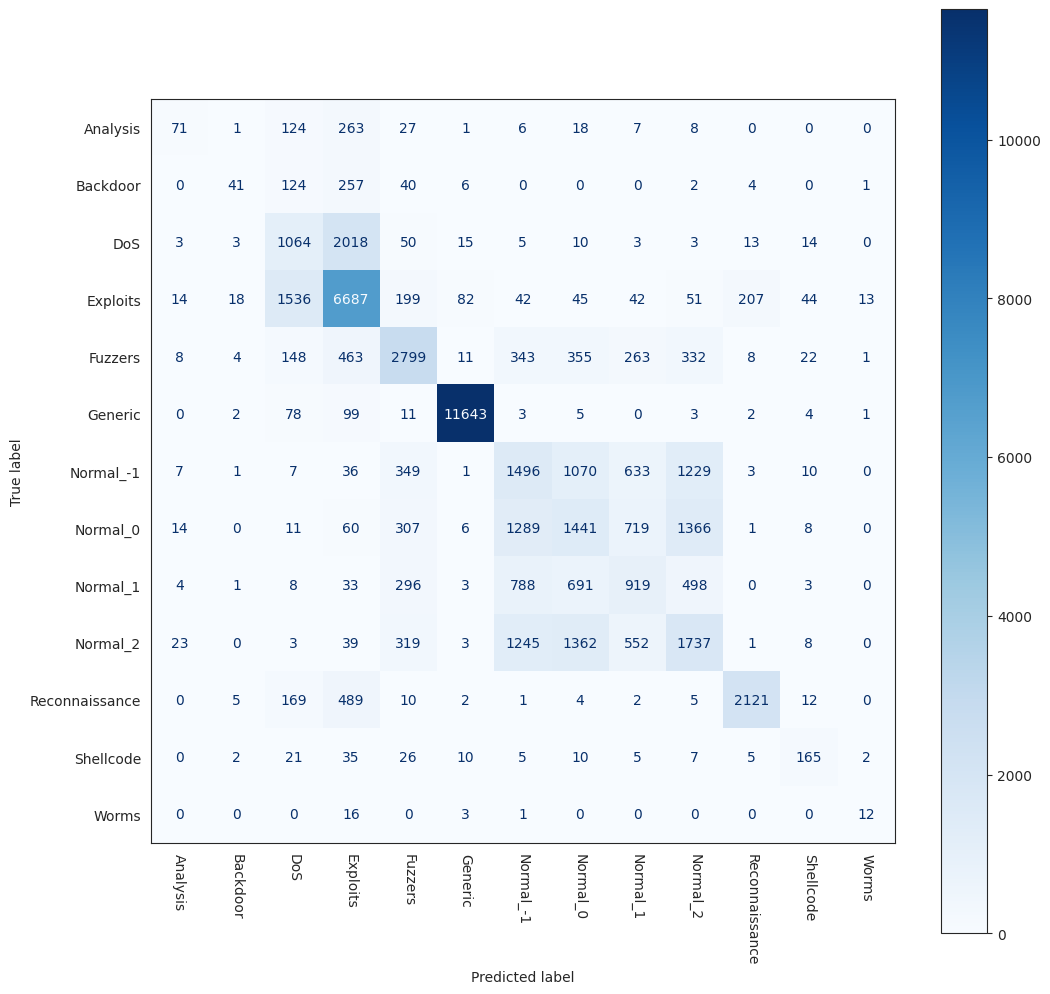

In [10]:
# confusion matrix and decision tree
data_train = df_250k_500_10000.drop(df_250k_500_10000[df_250k_500_10000['train_test'] == 1].index).reset_index(drop=True)
data_test = df_250k_500_10000.drop(df_250k_500_10000[df_250k_500_10000['train_test'] == 0].index).reset_index(drop=True)
x_train = data_train.loc[:, :'state_RST']
x_test = data_test.loc[:, :'state_RST']
y_train_class = data_train.iloc[:, -2]
y_test_class = data_test.iloc[:, -2]
# decision_tree(X_train, X_test, y_train)
model, y_predictions = decision_tree(x_train, x_test, y_train_class)
confusion_matrix_plot(model, y_test_class, y_predictions)

In [11]:
# look at random forest specifically on the normals
df_250k_500_10000_normal = df_250k_500_10000.drop(df_250k_500_10000[df_250k_500_10000['label'] == 1].index).reset_index(drop=True)
df_250k_500_10000_normal = df_250k_500_10000_normal.drop('rate', axis = 1)
data_train = df_250k_500_10000_normal.drop(df_250k_500_10000_normal[df_250k_500_10000_normal['train_test'] == 1].index).reset_index(drop=True)
data_test = df_250k_500_10000_normal.drop(df_250k_500_10000_normal[df_250k_500_10000_normal['train_test'] == 0].index).reset_index(drop=True)
x_train = data_train.loc[:, :'state_RST']
x_test = data_test.loc[:, :'state_RST']
y_train_class = data_train.iloc[:, -2]
y_test_class = data_test.iloc[:, -2]

rf_model, y_predicitons_rf = random_forest(x_train, x_test, y_train_class)

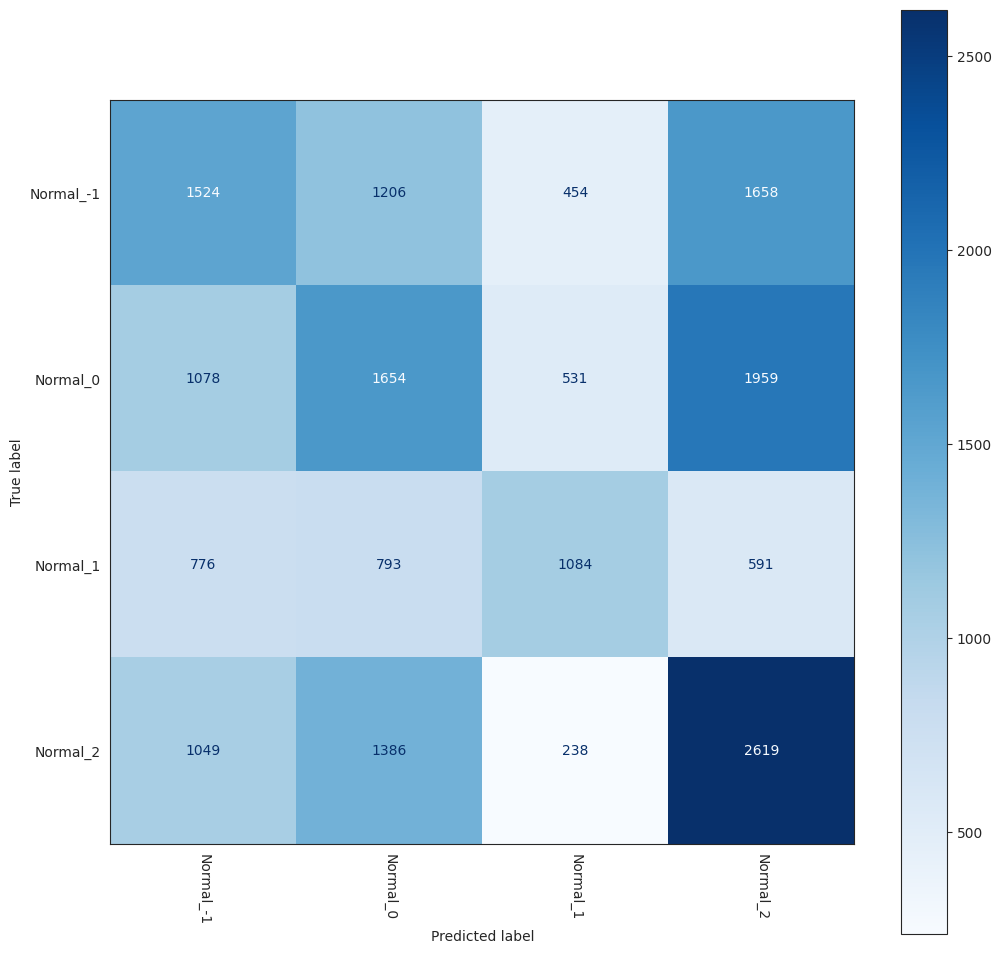

In [12]:
confusion_matrix_plot(rf_model, y_test_class, y_predicitons_rf)

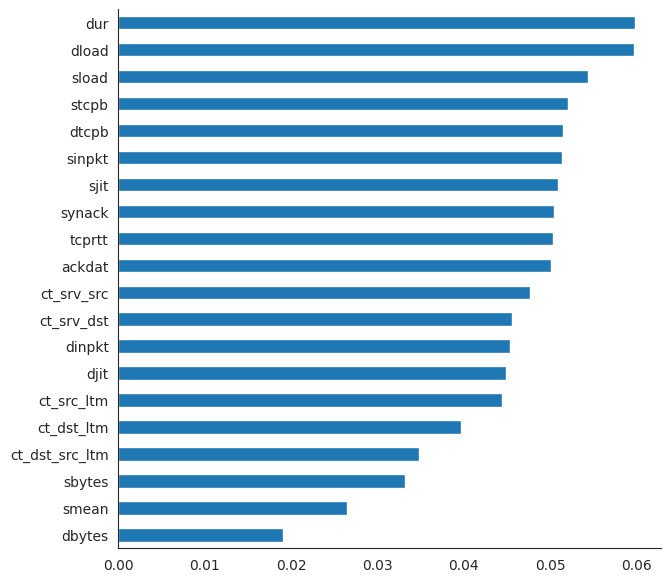

In [13]:
# feature importance on the normal traffic
x = df_250k_500_10000_normal.loc[:, :'state_RST']
feature_importance_plot(x, rf_model)